# Illustrative examples on how to compute the Median Average Similarity (MAS)

MAS is a novel metric used to assess predictions of RNA structures using probing scores experimentally determined for profiling RNA structures, such as PARS and SHAPE. Unlike classical metrics used for making such assessments, MAS exclusively uses probing scores instead of reference RNA structure commonly represented in dot-bracket notation. This is of practical importance because such reference structures are frequently estimated by computational methods whose predictions are constrained using probing data, which may incorporate biases which can ultimately impact on metrics.

This notebook presents a series of examples which illustrate how to use MAS to assess the correctness of diverse RNA predicted structures using synthetic probing scores for a toy RNA sequence.

Since MAS is a similarity metric: the higher it is, the most correct a prediction is with respect to the probing data. MAS returns values between 0 and 1.

## Notebook initialization

In [ ]:
#@title Imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# global variable
tol = 0.1

In [ ]:
#@title Library installation
!wget -q https://github.com/DasLab/draw_rna/archive/refs/heads/master.zip > /dev/null
!unzip master.zip > /dev/null
%cd draw_rna-master
!python setup.py install > /dev/null

sys.path.insert(1, "/contents/draw_rna-master/")
import draw_rna.draw as draw
from draw_rna.draw_utils import seq2col

/content/draw_rna-master
zip_safe flag not set; analyzing archive contents...


In [ ]:
#@title Utils
def bin2dot(bina, thr=0.5):
    N = len(bina)
    dots = list('.'*N)
    for i in range(N):
        if bina[i]>thr: # basic symmetric stem-loop
            if i>=N/2: dots[i] = ')'
            else: dots[i] = '('

    return "".join(dots)

def plot_errors(scores, ref_fold, fold, masp, masu, mas, tol=0.1, rna=True):
    f, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

    if rna:
        #draw.draw_rna(seq, ref_fold, seq2col(seq), ax=axs[0])
        draw.draw_rna(seq, bin2dot(fold), seq2col(seq), ax=axs[0])

    x = range(1,len(scores)+1)
    axs[1].plot(x, scores, 'o-', label=r'Reference')
    axs[1].plot(x, fold, 'o-', label='Prediction', zorder=-1)

    # plot errors
    axs[1].plot((x,x), 
                ([s for s in scores], [f for f in fold]),
                'k-', label='Error',
                zorder=-10)
    
    axs[1].fill_between(x, scores, fold, color='black', alpha=0.1)
    
    # line indicating for pairing and unpairing scores
    axs[1].hlines(0.5, *axs[1].get_xlim(), linewidth=.5)

    # plot tolerance
    axs[1].hlines(0.5 + tol/2, *axs[1].get_xlim(), ls=(0, (5, 10)), lw=.8, label='Tolerance/2')
    axs[1].hlines(0.5 - tol/2, *axs[1].get_xlim(), ls=(0, (5, 10)), lw=.8, label='Tolerance/2')


    handles, labels = axs[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    by_label['MAS-: {:.2f}'.format(masu)] = Line2D([0], [0], color='white')
    by_label['MAS+: {:.2f}'.format(masp)] = Line2D([0], [0], color='white')
    by_label['MAS : {:.2f}'.format(mas)] = Line2D([0], [0], color='white')

    axs[1].legend(by_label.values(), by_label.keys(),
                  prop={'family': 'monospace'},
                  loc="center left", bbox_to_anchor=(1, 0.5))

    axs[1].set_xlabel('Index (nt)')
    axs[1].set_ylabel('Scaled score / Prediction')

    axs[1].set_xlim([0.5, len(scores)+.5])

    axs[0].set_title('Prediction')
    axs[1].set_title('MAS calculation')
    
    plt.show()

In [ ]:
#@title MAS and method for scaling probing scores
def scale_probing(scores, source):
    """
    Scale the structural probing scores in the range [0, 1], where 0 is not 
    paired and 1 is paired.
        
    Parameters
    ----------
    scores : array[float]
        Structural probing scores, same size as the RNA sequence
    source : str
        Probing method from the following:

        TODO: check details
        'PARS': original log scale (cite2010)
        
        'nextPARS': from linear scores (SHAPE-like by Uciel Chorostecki2021 https://doi.org/10.1007/978-1-0716-1307-8_4)
                    "score for each nucleotide that ranges from −1.0 (highest preference for single strand)
                    to 1.0 (highest preference for double-strand)."
                    https://github.com/Gabaldonlab/nextPARS_docker
        
        'SHAPE': input scores in (0,1) 0=>match (double strand) and 1=>non-match (single strand)
                (Chillon2015 https://dx.doi.org/10.1016/bs.mie.2015.01.008)
                preprocessing: https://colab.research.google.com/drive/1uFgjb4uesAvYHPRhFqfkyMJ5bQec8rgP
                - mark with -999 the undetermined nucleotides
                - remove negative values (replace with -999)
                - replace scores>1 with 1.0
                - (do not scale/transform values in the range (0,1) because they have a particular meaning in the standard.
                output 1-score
        'SHAPE-D': apply ln and then linear scale
                (Deigan2009 https://doi.org/10.1073/pnas.0806929106)
                (default in RNAfold https://www.tbi.univie.ac.at/RNA/RNAfold.1.html)
                [HOTAIR, PAN]?
        
        np.nan: nt without measurement => assing 0.5 (then exclude them with tol>0.0
        in the MAS function)
    
    Returns
    -------
    nscores
        Normalized scores
    """
    s = scores.copy()
    
    if source=="PARS":
        nscores = (s + 7) / (2*7)
    elif source=="nextPARS":
        nscores = (s + 1) / 2 
    elif source=="SHAPE":
        nscores = 1 - s
    elif source=="SHAPE-D":
        shD = 1.8*np.log(s+1)-0.6
        shD[shD<-2.0] = -2.0
        shD[shD>2.0] = 2.0
        nscores = (shD+2.0)/4.0
    else:
        print("WARNING: scaling not applied")
        nscores = s

    nscores[np.isnan(nscores)] = 0.5    
    return nscores 

def mas_score(pred, nscores, tol=0.1):
    """
    Mean absolute similarity (MAS) between binary predictions and biochemical 
    probing scores.   

    Parameters
    ----------
    pred : array[int]
        Paired-unpaired prediction for each nucleotid in {0, 1}, where 0 is 
        unpaired and 1 is paired
    nscores : array[float]
        Probing score for each nucleotid in [0, 1], where 0 is high score for 
        unpaired and 1 high score for paired
    tol : float
        Nucleotids with abs(score)<=tol are ignored
    
    Returns
    -------
    MASu, MASp, MAS : float
        paired MAS, unpaired MAS and average MAS. 
    """
    i_pos = nscores > 0.5 + tol/2
    i_neg = nscores <= 0.5 - tol/2
    Npos = sum(i_pos)
    Nneg = sum(i_neg)
       
    diff = pred - nscores
    
    mas_pos = 1 - np.absolute(diff[i_pos]).mean()
    mas_neg = 1 - np.absolute(diff[i_neg]).mean()
    
    # best and worst cases for normalization
    ref_ideal = np.ones((len(nscores),))
    ref_ideal[nscores<=tol/2+0.5] = 0.0
    
    diff_ideal = ref_ideal - nscores
    diff_worst = (1-ref_ideal) - nscores
    
    max_mas_pos = 1 - np.absolute(diff_ideal[i_pos]).mean() 
    max_mas_neg = 1 - np.absolute(diff_ideal[i_neg]).mean()     
    min_mas_pos = 1 - np.absolute(diff_worst[i_pos]).mean() 
    min_mas_neg = 1 - np.absolute(diff_worst[i_neg]).mean()     
    
    MASp = (mas_pos - min_mas_pos) / (max_mas_pos - min_mas_pos) 
    MASu = (mas_neg - min_mas_neg) / (max_mas_neg - min_mas_neg) 
    
    # simple average
    ave_mas = 1 - np.absolute(diff[i_pos | i_neg]).mean() 
    
    # normalized average
    max_ave_mas = 1 - np.absolute(diff_ideal[i_pos | i_neg]).mean()
    min_ave_mas = 1 - np.absolute(diff_worst[i_pos | i_neg]).mean()
    MAS = (ave_mas - min_ave_mas) / (max_ave_mas - min_ave_mas) 

    return MASp, MASu, MAS

## Examples

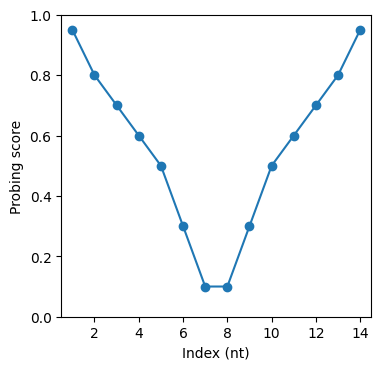

In [ ]:
#@title Probing scores for the structure of a toy RNA sequence
#@markdown Let `AAAACCACAGUUUU` be our toy RNA sequence, the figure below shows probing scores synthetically generated for each nucleotide of this sequence. The higher a probing score, the higher the probability that its corresponding nucleotide is paired.
seq  = "AAAACCACAGUUUU"

# synthetic nextPARS scores
scores = np.array([
  0.9,  0.6,  0.4,  0.2,
  0.0, -0.4, -0.8, -0.8, 
 -0.4,  0.0,  0.2,  0.4,  
  0.6,  0.9])
Nref = len(scores)

# scale scores to be within the interval [0, 1]
scaled_scores = scale_probing(scores, 'nextPARS')

# plot scaled scores
fig, axs = plt.subplots(figsize=(4,4), dpi=100)
axs.plot(range(1,len(scores)+1), scaled_scores, 'o-')

axs.set_xlim([0.5, scaled_scores.shape[0]+.5])
axs.set_ylim([0, 1])

axs.set_xlabel('Index (nt)')
axs.set_ylabel('Probing score')
plt.show()

Although these scores can be used to infer a "reference" RNA structure, as is shown below, note how this structure representation leads to a loss of information, as it is not encoding the likelihood of pairing of each nucleotide. 

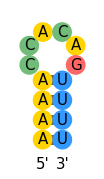

In [ ]:
#@title A possible dot-bracket structure inferred from probing scores
# this a hypothetical structure, in dot-bracket format, derived from the scores
ref = "((((......))))"
draw.draw_rna(seq, ref, seq2col(seq))

Based on these probing scores, the cells below illustrate graphically how the MAS is calculated from different predicted structures, especially designed to show different types of prediction errors.

Note that the predicted structures are represented in dot-bracket format, as is usually done by predictive methods. Therefore, each of them simply indicates different pairing (1) and unpairing (0) patterns for the nucleotides of the toy RNA.

In [ ]:
#@title Predicted structures

fold_ideal = np.ones((Nref,))
fold_ideal[scores<=0] = 0.0

fold_err_1pos = np.array([1, 1, 1, 0, 
                          0, 0, 0, 0, 
                          0, 0, 0, 1, 
                          1, 1])

fold_err_2pos = np.array([1, 1, 0, 0, 
                          0, 0, 0, 0, 
                          0, 0, 0, 0, 
                          1, 1])

fold_err_xpos = np.array([1, 0, 0, 0, 
                          0, 0, 0, 0, 
                          0, 0, 0, 0, 
                          0, 1])

fold_err_2neg = np.array([1, 1, 1, 1, 
                          1, 1, 0, 0, 
                          1, 1, 1, 1, 
                          1, 1])

fold_err_2bulge = np.array([1, 0, 1, 1, 
                            0, 0, 0, 0, 
                            0, 0, 1, 1, 
                            1, 0])

fold_err_allpos_2neg = np.array([0, 0, 0, 0, 
                                 1, 1, 0, 0, 
                                 1, 1, 0, 0, 
                                 0, 0])

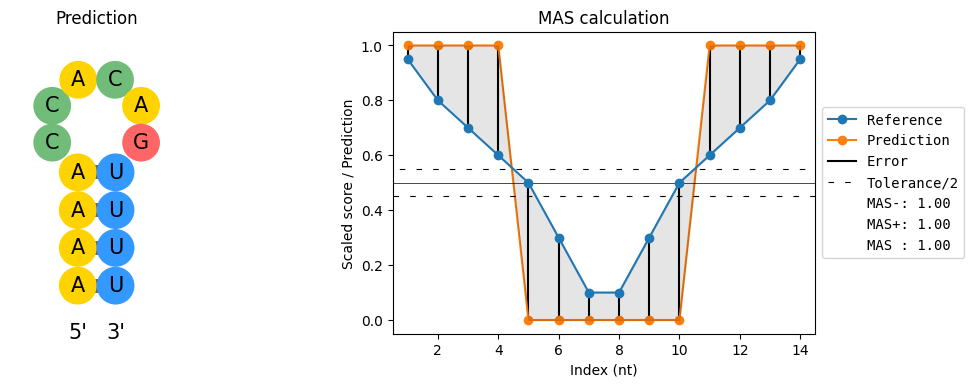

In [ ]:
plot_errors(scaled_scores, ref, fold_ideal, tol=tol, *mas_score(fold_ideal, scaled_scores, tol=tol))

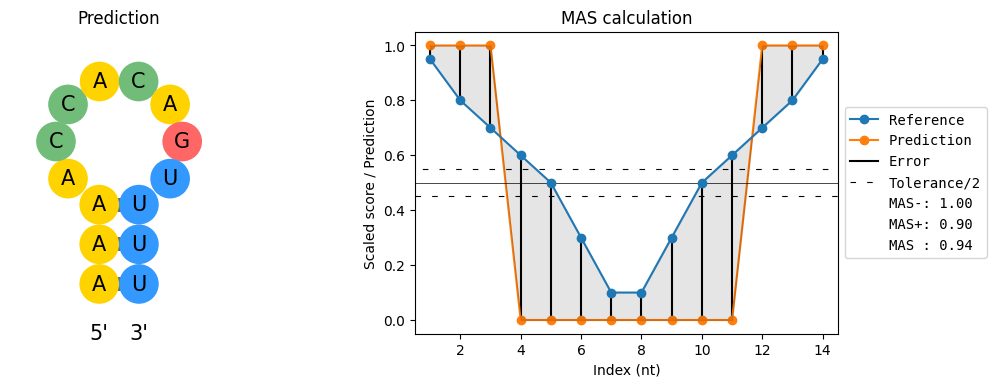

In [ ]:
plot_errors(scaled_scores, ref, fold_err_1pos, *mas_score(fold_err_1pos, scaled_scores, tol=tol))

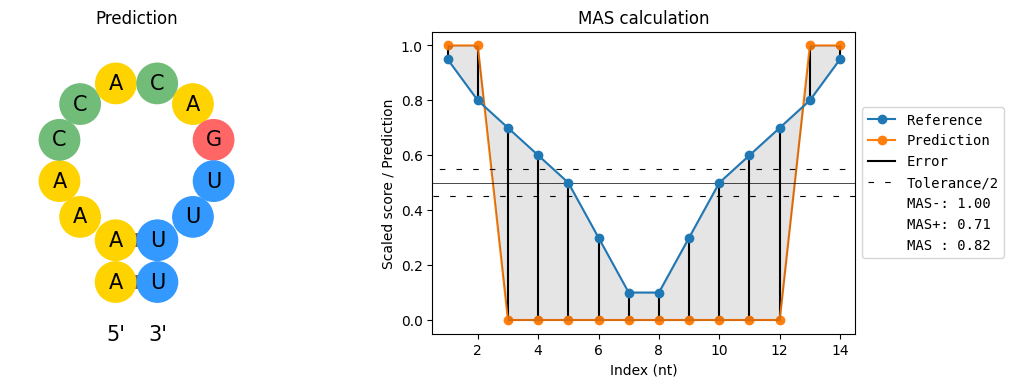

In [ ]:
plot_errors(scaled_scores, ref, fold_err_2pos, *mas_score(fold_err_2pos, scaled_scores, tol=tol))

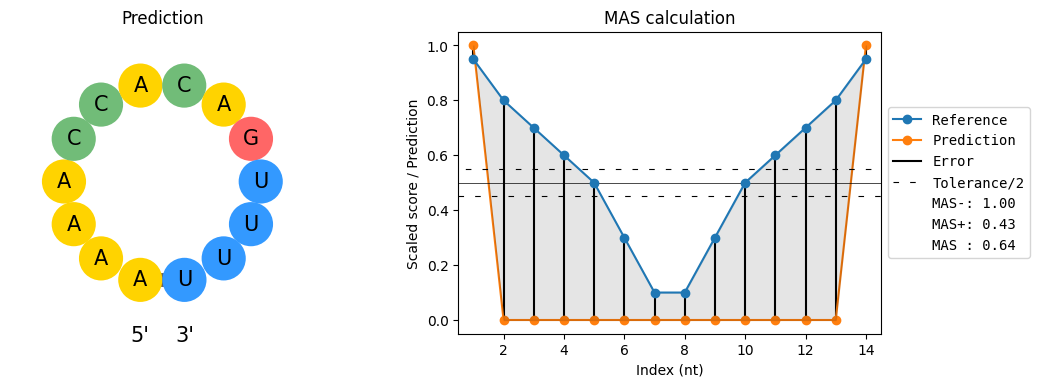

In [ ]:
plot_errors(scaled_scores, ref, fold_err_xpos, *mas_score(fold_err_xpos, scaled_scores, tol=tol))

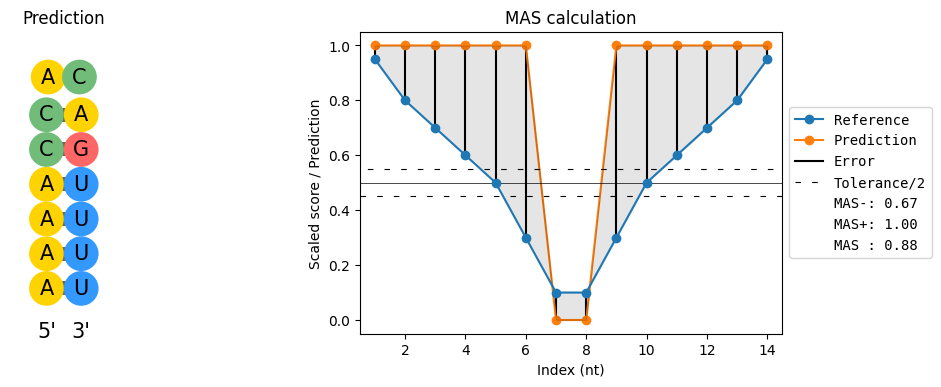

In [ ]:
plot_errors(scaled_scores, ref, fold_err_2neg, *mas_score(fold_err_2neg, scaled_scores, tol=tol))

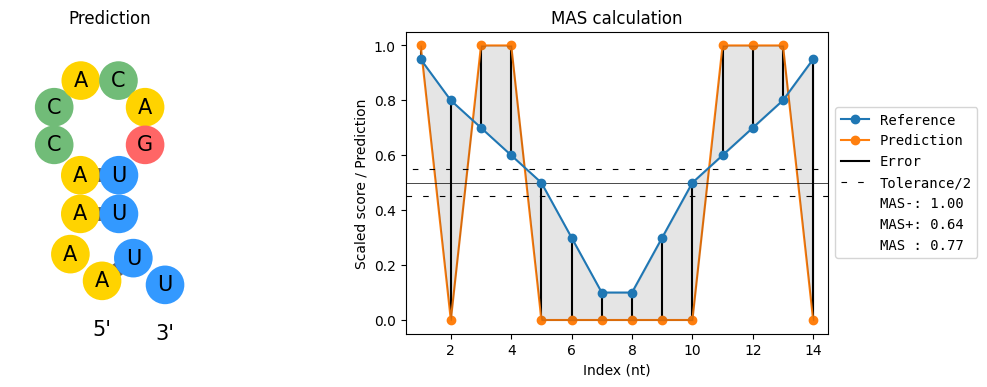

In [ ]:
plot_errors(scaled_scores, ref, fold_err_2bulge, *mas_score(fold_err_2bulge, scaled_scores, tol=tol))

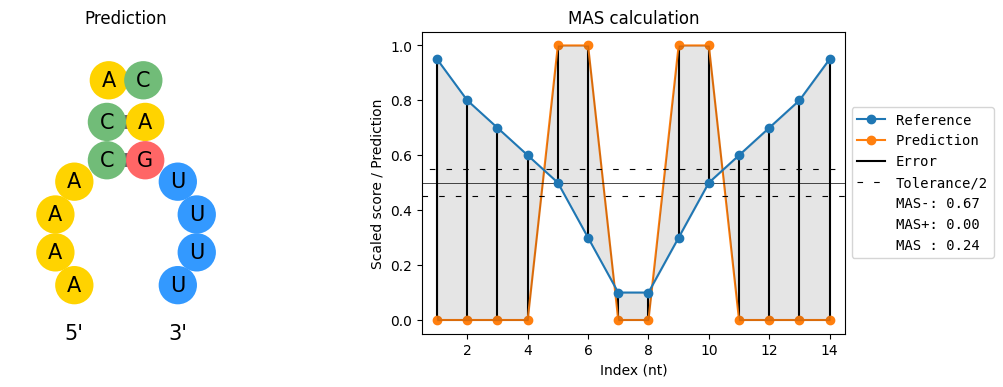

In [ ]:
plot_errors(scaled_scores, ref, fold_err_allpos_2neg, *mas_score(fold_err_allpos_2neg, scaled_scores, tol=tol))